In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

# SIR Model with Demography

Use $\texttt{scipy.integrate.odeint}$ (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to simulate the SIR model with demography.


Consider: 
- $\beta = 520$
- $\mu = 365. / 7.
- $\gamma = 1. / 80$
- $N=10^7$
- $t_0 =0$, $t_f=60$, with $500$ steps

Initial conditions: 
- $S(0) = 0.1 * N$
- $I(0) = 2.5 * 10**(-4) * N$
- $R(0) = (1 - 2.5 * 10**(-4) - 0.1) * N$

Verify the endemic state: 
$$I(\infty) = N \frac{\gamma}{\beta} (R_0 - 1)$$

And the oscillation period:

$$ T \sim 2 \pi \sqrt{AG}$$


With: 
- $A = \frac{1}{\gamma (R_0 - 1)}$
- $G = \frac{1}{\gamma + \mu}$

In [2]:
# define ODE system
def sir_model_demography_ode(y, t, beta, mu, gamma, N): 
    dydt = [gamma * N - beta * y[1] * y[0] / N - gamma * y[0],   # S
            +beta * y[1] * y[0] / N - mu * y[1] - gamma * y[1], # I 
            mu * y[1] - gamma * y[2] # R
            ]
    return dydt
    

# initial conditions and parameters
beta, mu, gamma = 520, 365. / 7., 1. / 80
N, I0 = 10**7, 10
y0 = [0.1 * N, 2.5 * 10**(-4) * N, (1 - 2.5 * 10**(-4) - 0.1) * N]
t = np.linspace(0, 60, 500)

# integrate
sol = odeint(sir_model_demography_ode, y0, t, args=(beta, mu, gamma, N))

In [3]:
# get endemic state
def sir_model_demography_endemic(N, gamma, beta, mu): 
    R0 = beta / (gamma + mu)
    return N * gamma / beta * (R0 - 1)

def get_oscillation_period(gamma, beta, mu): 
    R0 = beta / (gamma + mu)
    A = 1 / (gamma * (R0 - 1))
    G = 1 / (gamma + mu)

    return 2 * np.pi * np.sqrt(A * G)

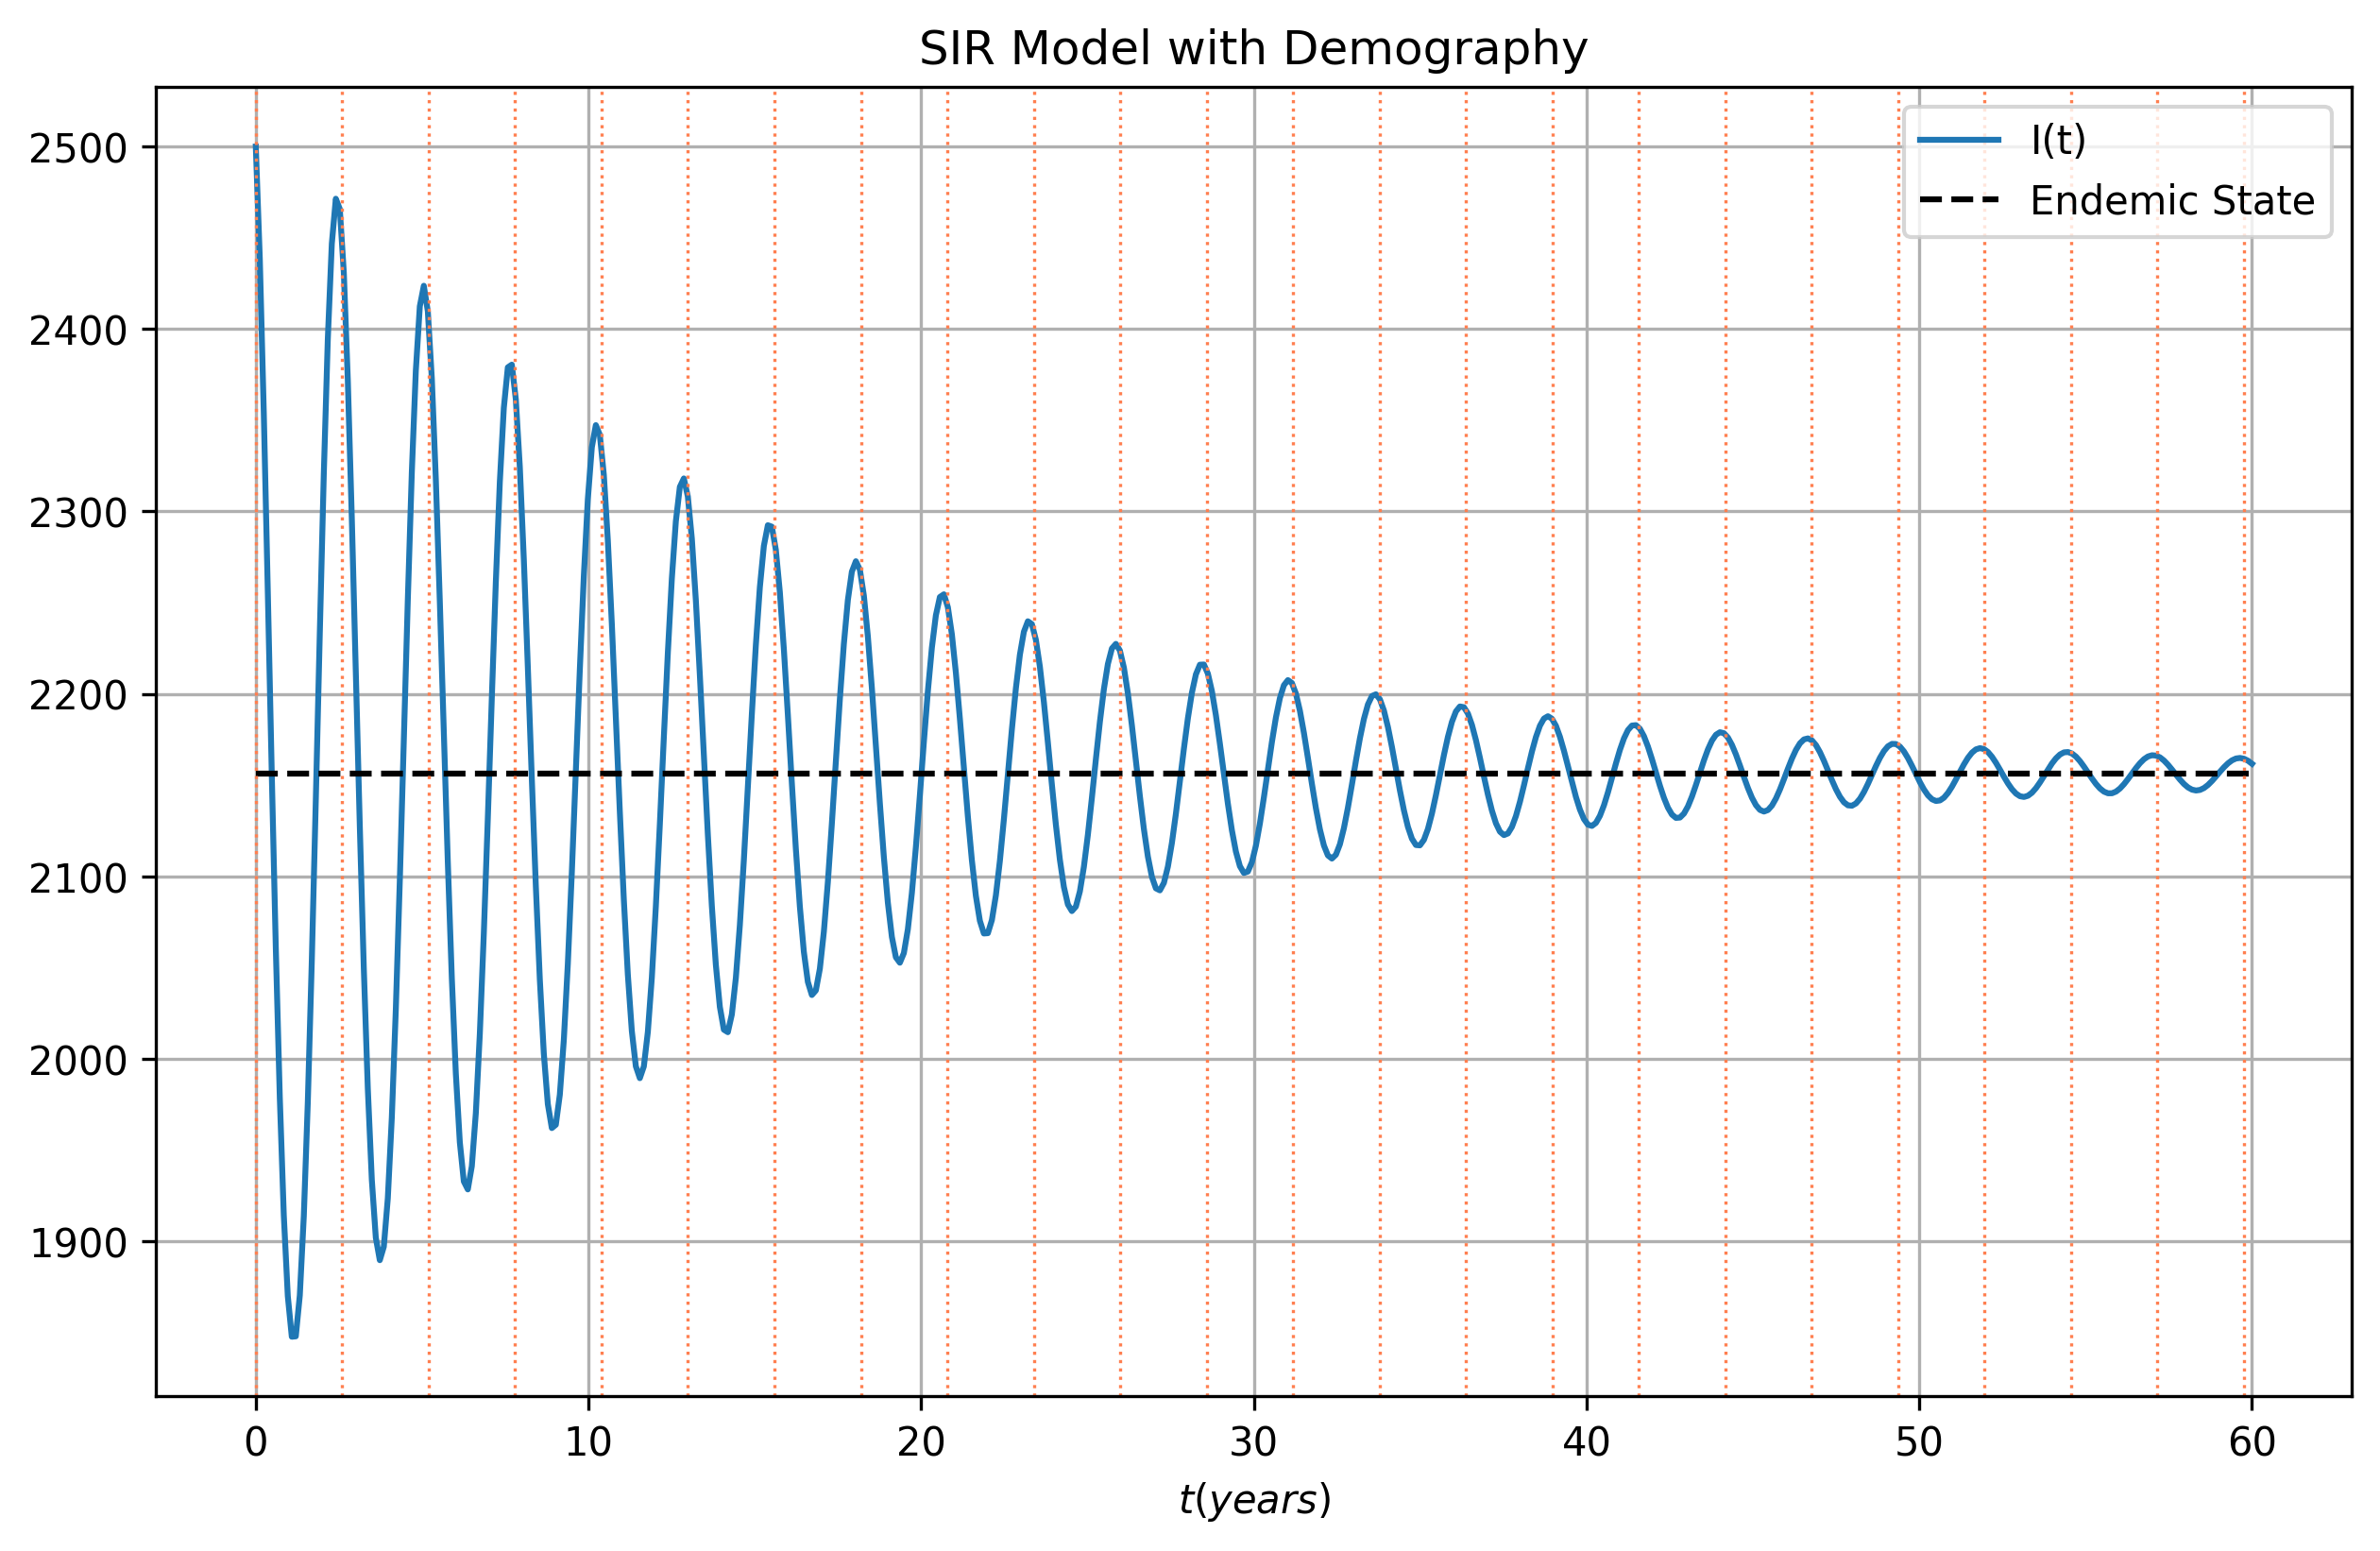

In [6]:
# plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
plt.plot(t, sol[:, 1], label='I(t)')

# plot endemic state
endemic_state = sir_model_demography_endemic(N, gamma, beta, mu)
plt.hlines(endemic_state, t[0], t[-1], label='Endemic State', color="k", linestyle="--")

# plot oscillation period
period = get_oscillation_period(gamma, beta, mu)

y1, y2 = ax.get_ylim()
for p in np.arange(t[0], t[-1], period): 
    ax.vlines(p, y1, y2, color="coral", linestyle="dotted", linewidth=0.8)
ax.set_ylim(y1, y2)

plt.xlabel('$t (years)$')
plt.title('SIR Model with Demography')
plt.legend()
plt.grid(True)
plt.show()

# SIR model with age structure and contact matrix

First, we import population data and contact matrix. We will consider Italy and Kenya as examples

<Axes: title={'center': 'Kenya'}, xlabel='Age'>

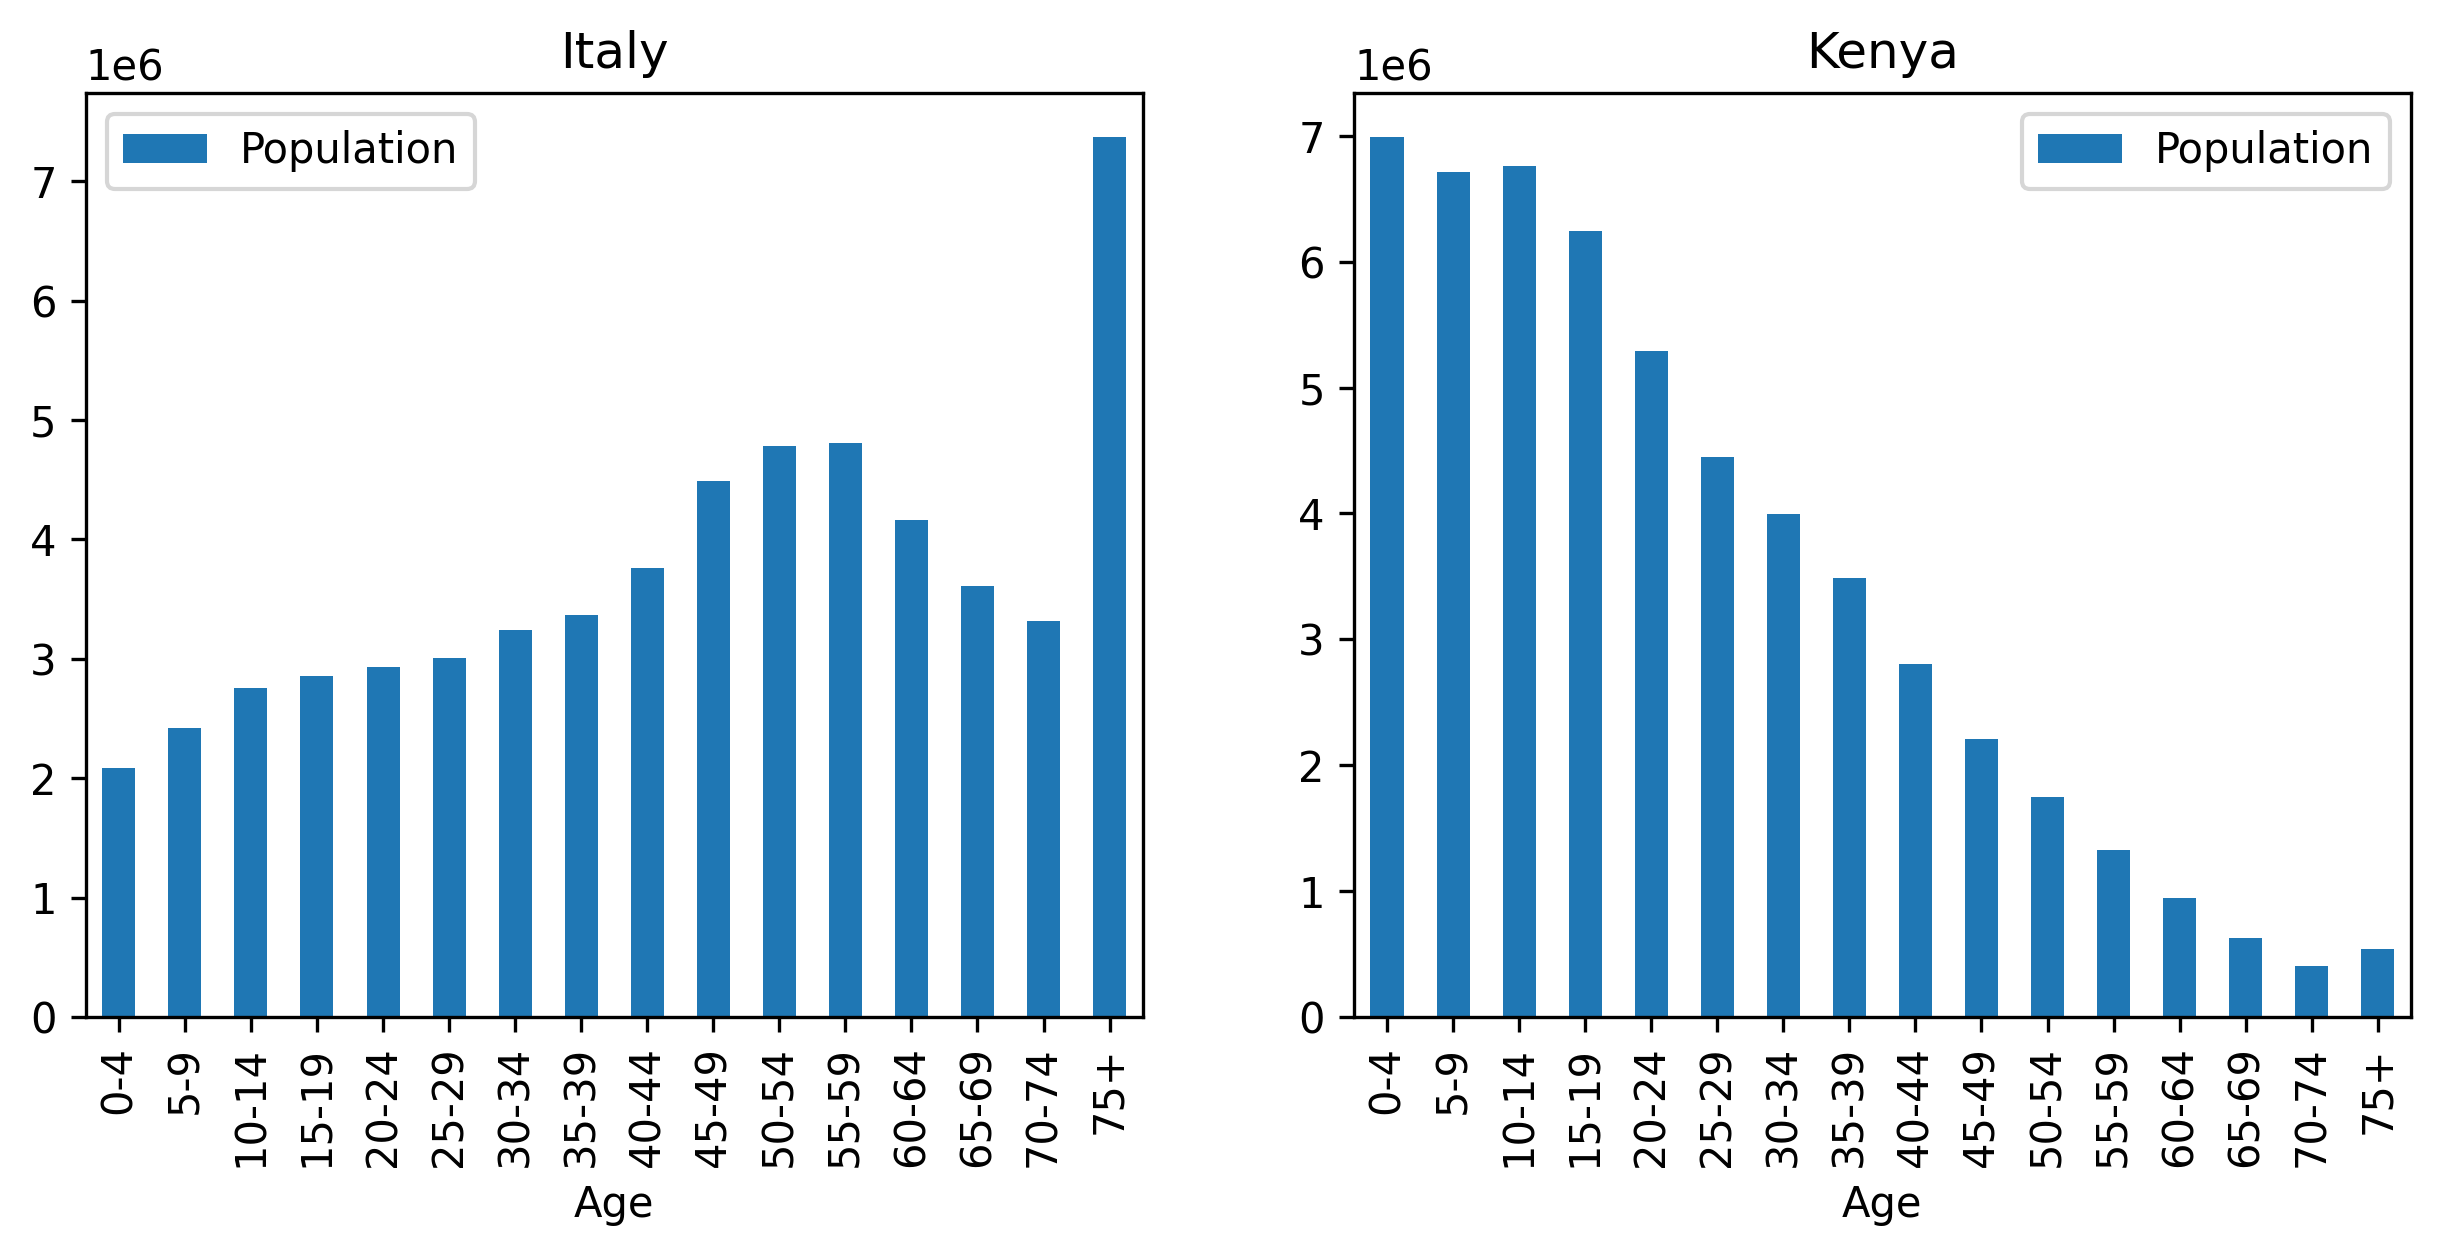

In [77]:
Nk_ita = pd.read_csv('../data/population/Italy-2023.csv')
Nk_kenya = pd.read_csv('../data/population/Kenya-2023.csv')

fig, axes = plt.subplots(figsize=(10, 4), dpi=300, ncols=2)
Nk_ita.plot.bar(x="Age", y='Value', title="Italy", label="Population", ax=axes[0])
Nk_kenya.plot.bar(x="Age", y='Value', title="Kenya", label="Population", ax=axes[1])

In [78]:
def import_contact_matrix(country, layer, filenumber=1):
    return pd.read_excel(f"../data/contact_matrices/MUestimates_{layer}_{filenumber}.xlsx", sheet_name=country)

layers = ["school", "work", "home", "other_locations", "all_locations"]

contacts_italy, contacts_kenya = {}, {}
for layer in layers:
    contacts_italy[layer] = import_contact_matrix("Italy", layer)
    contacts_kenya[layer] = import_contact_matrix("Kenya", layer)

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains

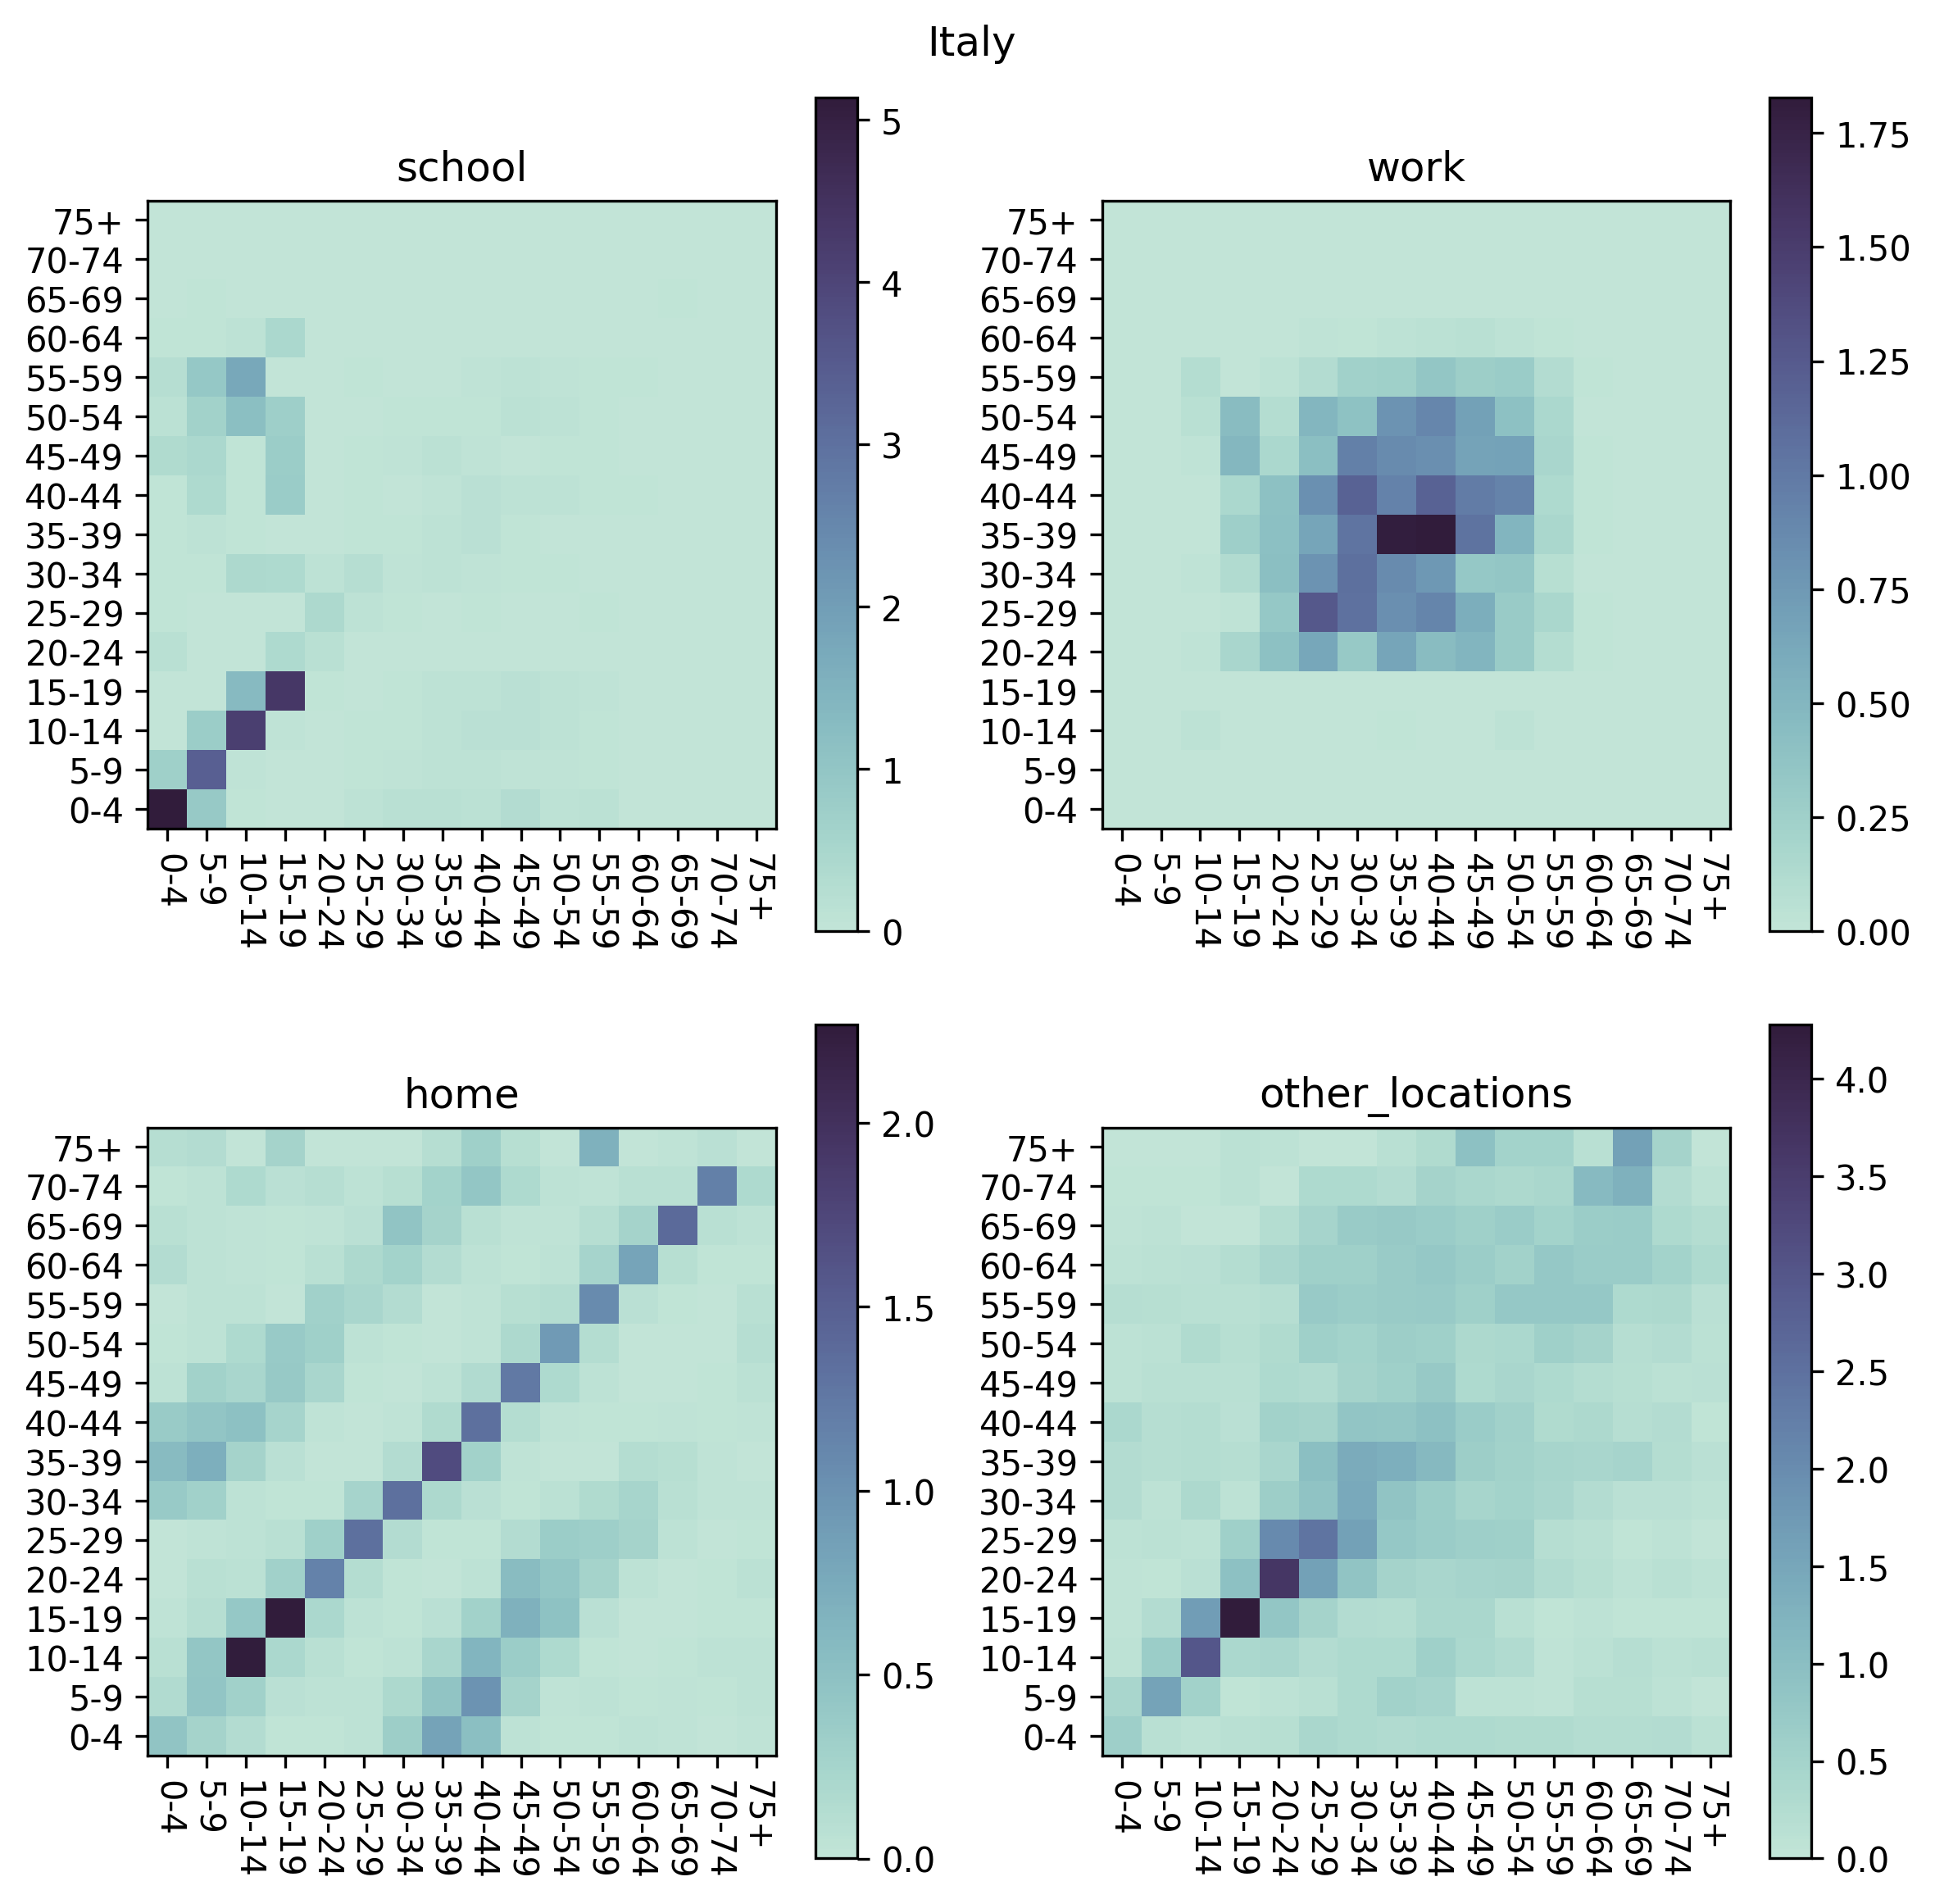

In [79]:
ages = Nk_ita.Age.unique()
def plot_contact_matrix(contact_matrix, ax, title):
    im = ax.imshow(contact_matrix, origin='lower', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    ax.set_title(title)
    ax.set_yticks(range(len(ages)))
    ax.set_yticklabels(ages)
    ax.set_xticks(range(len(ages)))
    ax.set_xticklabels(ages, rotation=-90)
    plt.colorbar(im, ax=ax)


fig, axes = plt.subplots(figsize=(8,8), dpi=300, ncols=2, nrows=2)
plot_contact_matrix(contacts_italy["school"], axes[0,0], "school")
plot_contact_matrix(contacts_italy["work"], axes[0,1], "work")
plot_contact_matrix(contacts_italy["home"], axes[1,0], "home")
plot_contact_matrix(contacts_italy["other_locations"], axes[1,1], "other_locations")

fig.suptitle("Italy")
plt.tight_layout()

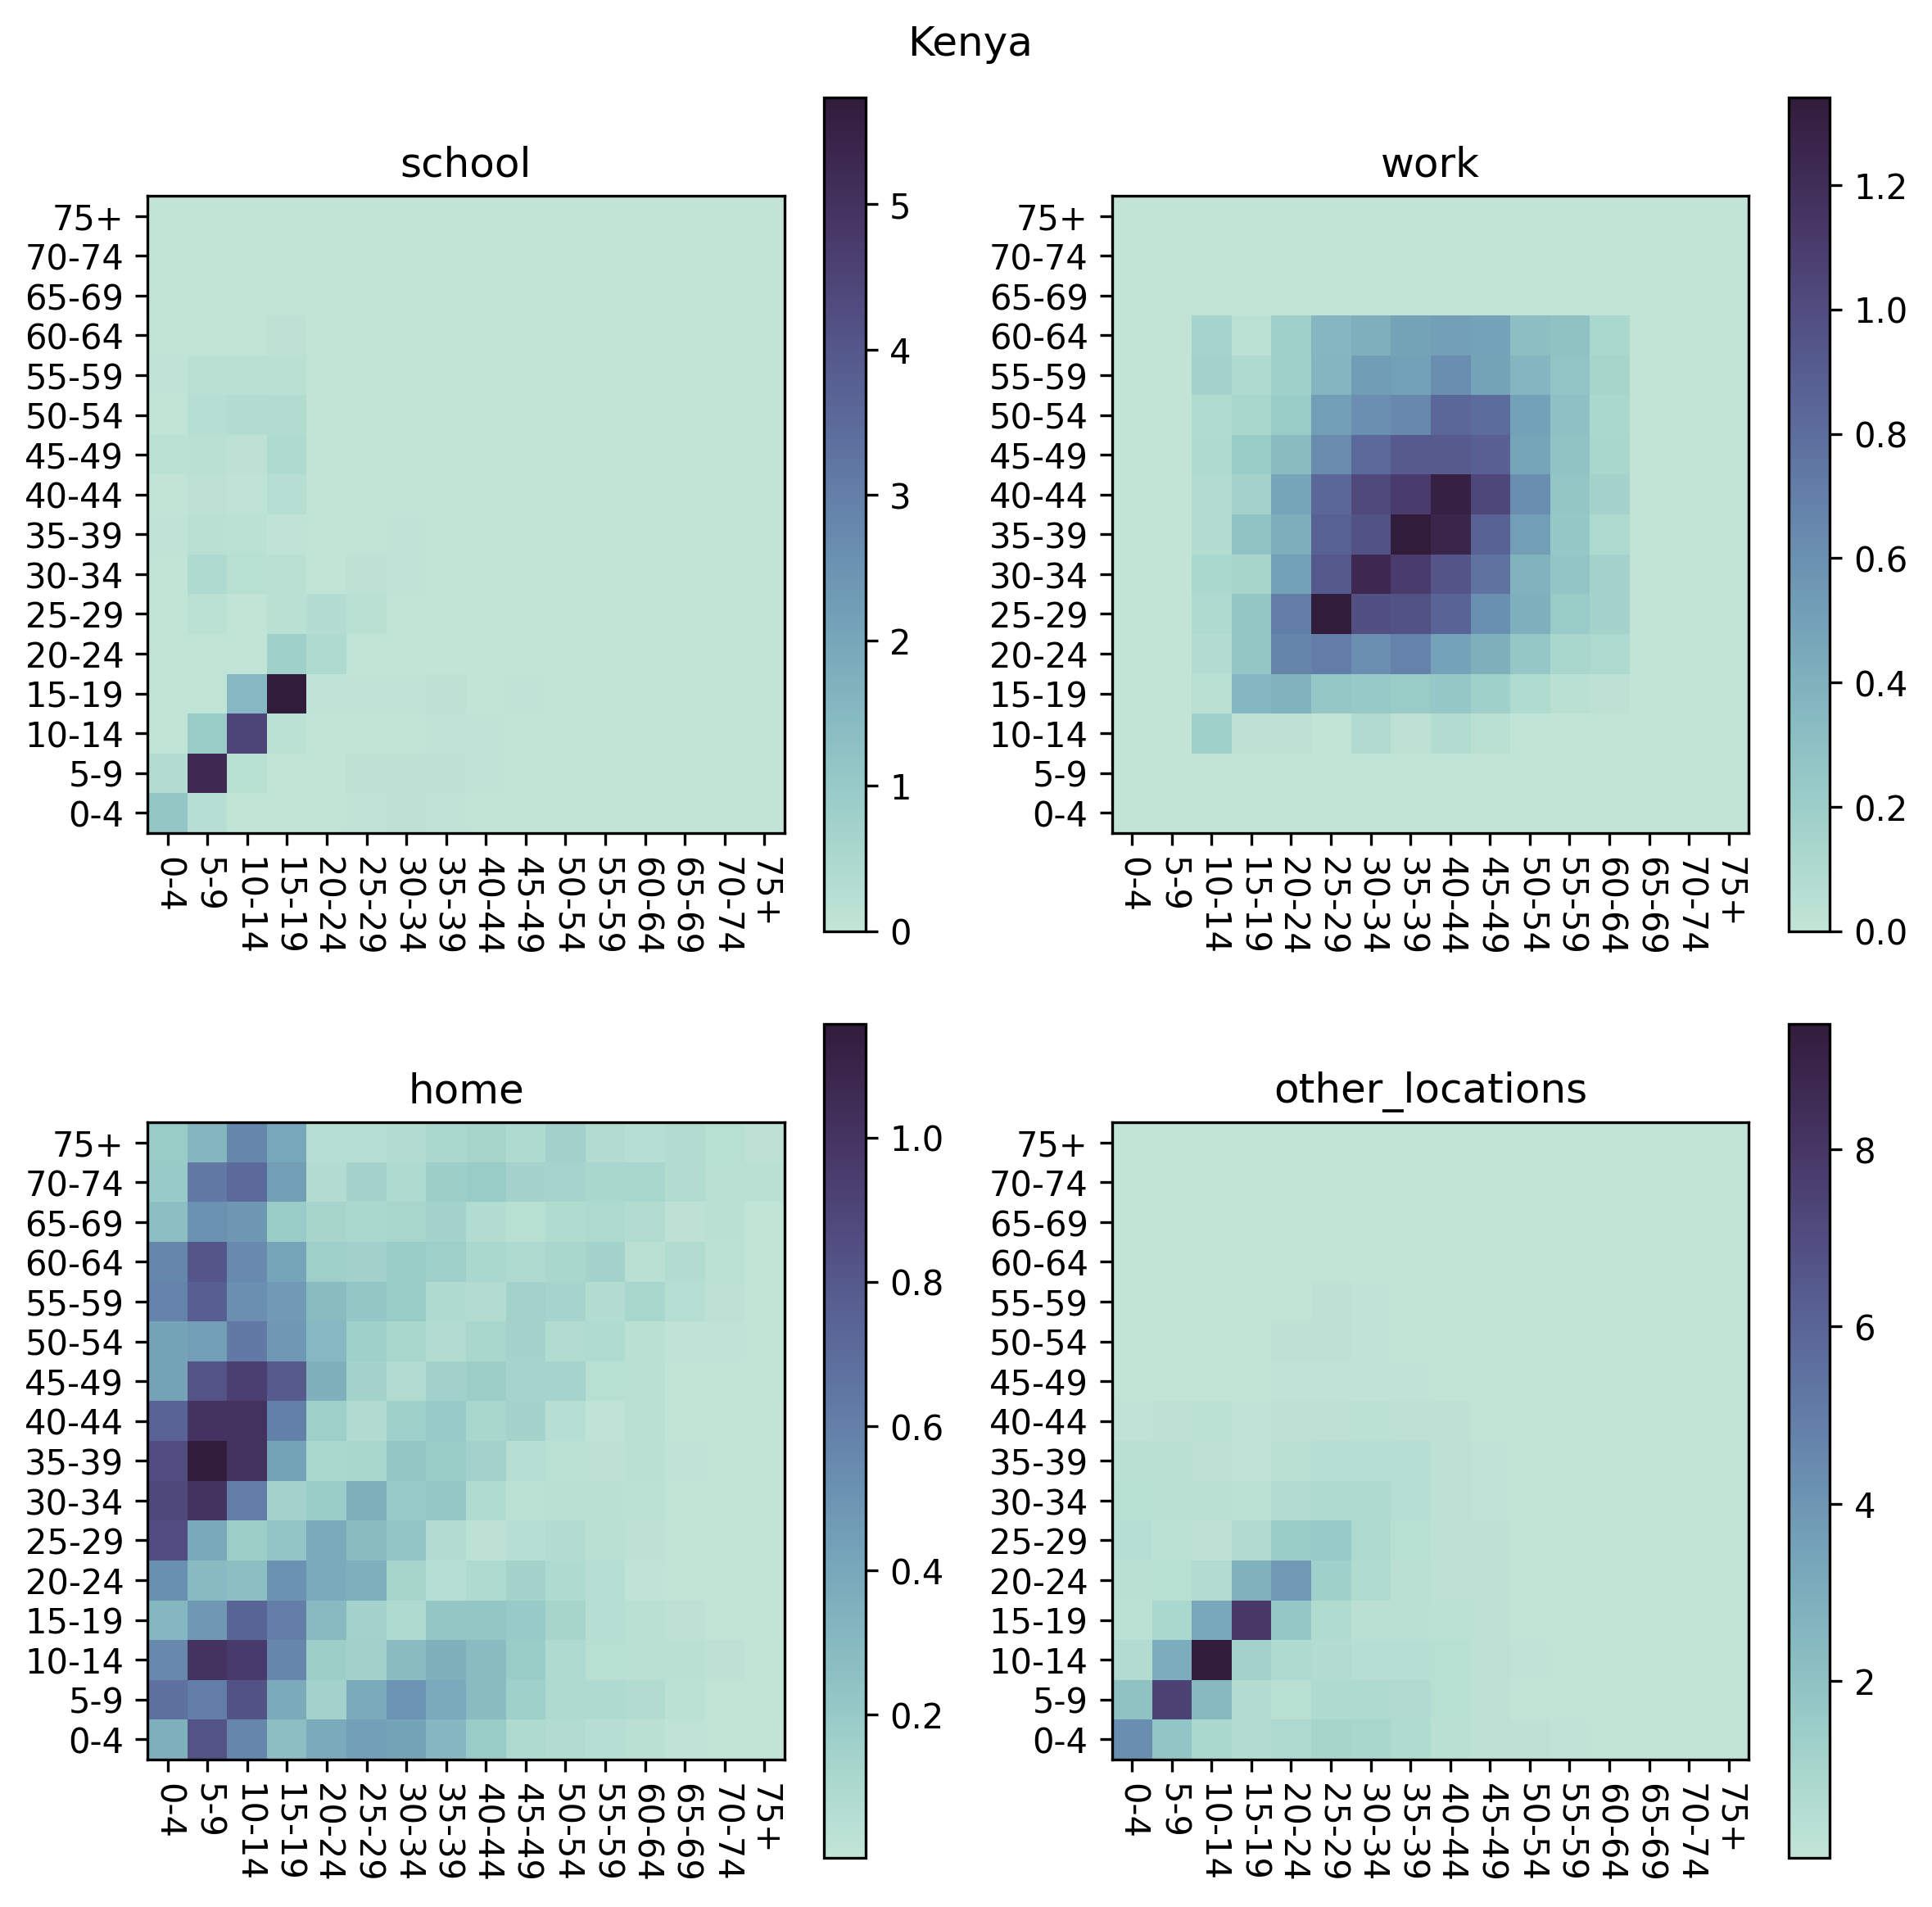

In [61]:
fig, axes = plt.subplots(figsize=(8,8), dpi=300, ncols=2, nrows=2)
plot_contact_matrix(contacts_kenya["school"], axes[0,0], "school")
plot_contact_matrix(contacts_kenya["work"], axes[0,1], "work")
plot_contact_matrix(contacts_kenya["home"], axes[1,0], "home")
plot_contact_matrix(contacts_kenya["other_locations"], axes[1,1], "other_locations")

fig.suptitle("Kenya")
plt.tight_layout()

Will the same disease spread the same in the two countries? Compute $R_0$ for the two countries when: 

- $\beta = 0.03$
- $\mu = 0.2$

Remember that $R_0 = \frac{\beta}{\mu} \rho(\tilde C)$, with $\tilde C_{ij} = C_{ij}\frac{N_i}{N_j}$

In [80]:
def compute_R0(beta, mu, Nk, contact_matrix): 
    contact_matrix_weighted = contact_matrix.copy()
    for i in range(contact_matrix.shape[0]):
        for j in range(contact_matrix.shape[1]):
            contact_matrix_weighted[i,j] = contact_matrix[i,j] * Nk[i] / Nk[j]

    rho = np.linalg.eigvals(contact_matrix_weighted).real.max()
    return beta * rho / mu

In [81]:
beta, mu = 0.03, 0.2

R0_italy = compute_R0(beta, mu, Nk_ita.Value.values, contacts_italy["all_locations"].values)
R0_kenya = compute_R0(beta, mu, Nk_kenya.Value.values, contacts_kenya["all_locations"].values)

print("R0 Italy:", R0_italy)
print("R0 Kenya:", R0_kenya)


R0 Italy: 2.5567522644480714
R0 Kenya: 3.4735066421275205


Implement the stochastic SIR model with age structure and contact matrix.

Consider: 
- $\beta = 0.03$
- $\mu = 0.2$
- initial percentage of infected $5\%$ homogeneously distributed among age groups

In [86]:
def stochastic_sir_age_structure(beta, mu, C, Nk, I0_perc, T_final, dt=1):
    """
    Function to simulate the stochastic SIR model with age structure.

    Parameters:
        beta (float): Infection rate
        gamma (float): Recovery rate
        C (array): Contact matrix
        Nk (array): Total population size by age group
        I0_perc (float): Fraction of number of infected individuals
        T_final (float): Final time to simulate

    Returns:
        S (array): Array of susceptible individuals over time and age groups
        I (array): Array of infected individuals over time and age groups
        R (array): Array of recovered individuals over time and age groups
        steps (array): Array of time steps over time and age groups
    """

    steps = np.arange(0, T_final + dt, dt)
    I0 = int(Nk.sum() * I0_perc)   # initial number of infected individuals
    nage = len(C)                  # number of age groups
    S, I, R = np.zeros((len(steps), nage)), np.zeros((len(steps), nage)), np.zeros((len(steps), nage))
    
    # initialize compartments
    for k in range(nage):
        I[0, k] = int(I0 / nage)
        S[0, k] = Nk[k] - I[0, k]

    # simulate
    for t in range(1, len(steps)):
        S_next, I_next, R_next = S[t-1].copy(), I[t-1].copy(), R[t-1].copy()
        for k in range(nage):
            new_infected_k = np.random.binomial(S[t-1, k], beta * np.sum(C[k, :] * I[t-1, :] / Nk) * dt)
            new_recovered_k = np.random.binomial(I[t-1, k], mu * dt)
            S_next[k] = S[t-1, k] - new_infected_k
            I_next[k] = I[t-1, k] + new_infected_k - new_recovered_k
            R_next[k] = R[t-1, k] + new_recovered_k
            
        S[t] = S_next
        I[t] = I_next
        R[t] = R_next
        
    return np.array(S), np.array(I), np.array(R), np.array(steps)


def get_beta(R0, mu, contact_matrix, Nk): 
    contact_matrix_weighted = contact_matrix.copy()
    for i in range(contact_matrix.shape[0]):
        for j in range(contact_matrix.shape[1]):
            contact_matrix_weighted[i,j] = contact_matrix[i,j] * Nk[i] / Nk[j]

    rho = np.linalg.eigvals(contact_matrix_weighted).real.max()
    return R0 / rho * mu

In [88]:
beta = get_beta(R0_italy, mu, contacts_italy["all_locations"].values, Nk_ita.Value.values)

S_ita, I_ita, R_ita, steps_ita = stochastic_sir_age_structure(beta, mu, 
                                                              C=contacts_italy["all_locations"].values, 
                                                              Nk=Nk_ita.Value.values, 
                                                              I0_perc=0.5 / 100., 
                                                              T_final=100, dt=1)

S_ken, I_ken, R_ken, steps_ken = stochastic_sir_age_structure(beta, mu, 
                                                              C=contacts_kenya["all_locations"].values, 
                                                              Nk=Nk_kenya.Value.values, 
                                                              I0_perc=0.5 / 100., 
                                                              T_final=100, dt=1)

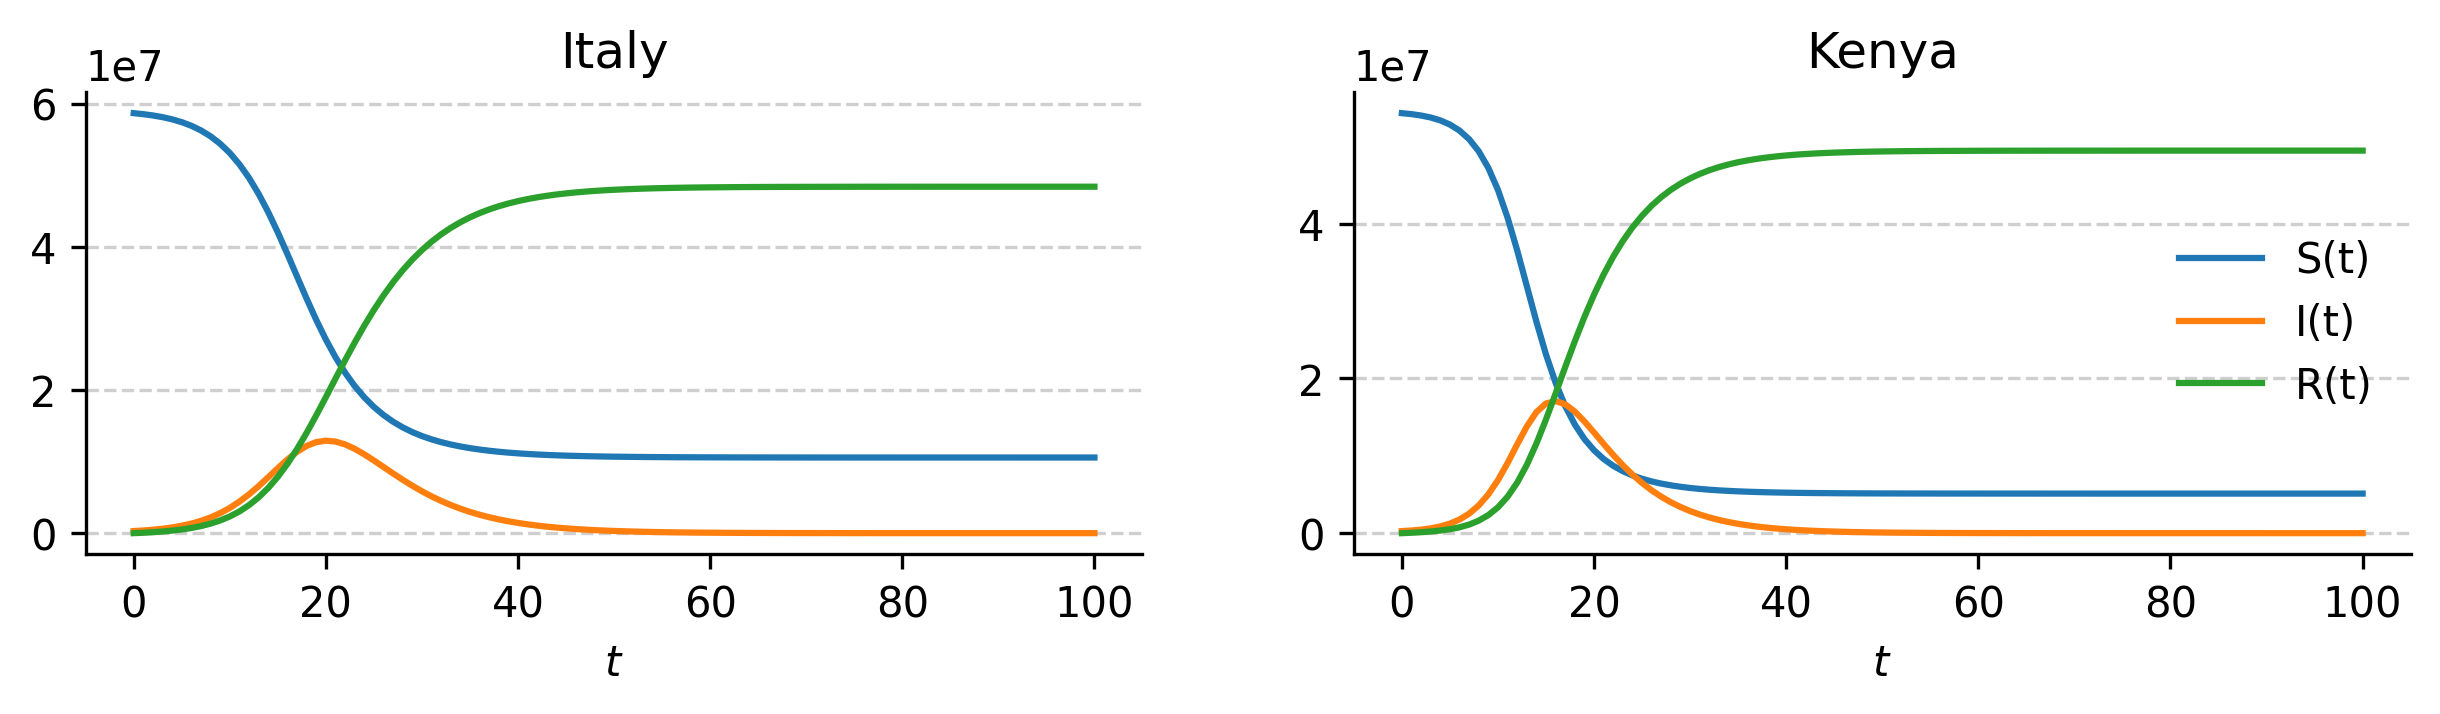

In [89]:
fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(10, 2))

axes[0].plot(np.sum(S_ita, axis=1), label="S(t)")
axes[0].plot(np.sum(I_ita, axis=1), label="I(t)")
axes[0].plot(np.sum(R_ita, axis=1), label="R(t)")
axes[0].set_title("Italy")

axes[1].plot(np.sum(S_ken, axis=1), label="S(t)")
axes[1].plot(np.sum(I_ken, axis=1), label="I(t)")
axes[1].plot(np.sum(R_ken, axis=1), label="R(t)")
axes[1].set_title("Kenya")

axes[1].legend(loc=5, frameon=False)
for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xlabel("$t$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [93]:
print("Attack Rate, Italy:", np.sum(R_ita, axis=1)[-1] / np.sum(Nk_ita.Value) * 100)
print("Attack Rate, Kenya:", np.sum(R_ken, axis=1)[-1] / np.sum(Nk_kenya.Value) * 100)

Attack Rate, Italy: 82.07748149504097
Attack Rate, Kenya: 90.62364317200021
